In [1]:
import numpy as np

from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params
# from eqaoa.qaoa_parameters.baseparams import QAOACircuitParams
from openqaoa.backends.simulators.qaoa_vectorized import QAOAvectorizedBackendSimulator
from openqaoa.backends.qpus.qaoa_qiskit_qpu import QAOAQiskitQPUBackend
from openqaoa.backends.qpus.qpu_auth import AccessObjectQiskit

from openqaoa.optimizers.training_vqa import ScipyOptimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *

In [2]:
cost_hamil = Hamiltonian([PauliOp('ZZ', (0, 1)), PauliOp('ZZ', (1, 2)), PauliOp('ZZ', (0, 2))], 
                         [1, 1, 1], 1)

In [3]:
mixer_hamil = X_mixer_hamiltonian(n_qubits=3)

In [4]:
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil, p=1)

In [5]:
variate_params = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [6]:
backend_obj = QAOAvectorizedBackendSimulator(circuit_params = circuit_params, append_state = None, prepend_state = None, init_hadamard = True)

Running 99/100

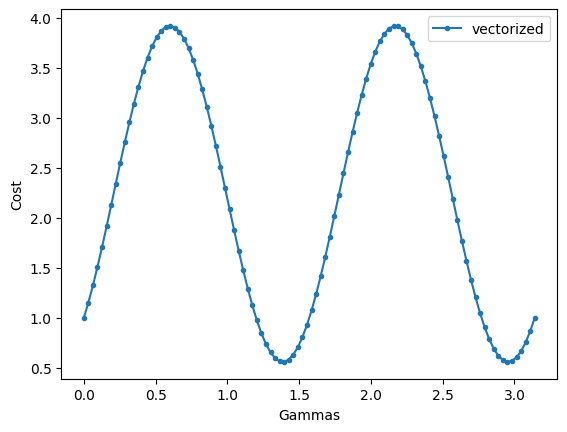

In [8]:
# Perform sweep

gammas = np.linspace(0, np.pi, 100)
beta = 1

costs_vect, costs = np.zeros((len(gammas))), np.zeros((len(gammas)))

for i, gamma in enumerate(gammas):
    print(f"\rRunning {i}/{len(gammas)}", end="")
    args = [beta, gamma]
    
    variate_params.update_from_raw(args)
    costs_vect[i] = backend_obj.expectation_w_uncertainty(variate_params)[0]
    
plt.plot(gammas, costs_vect, label = 'vectorized', marker = '.')
plt.ylabel('Cost')
plt.xlabel('Gammas')
plt.legend()
plt.show()

# Test prepend,append state, init_hadamard

Running 99/100

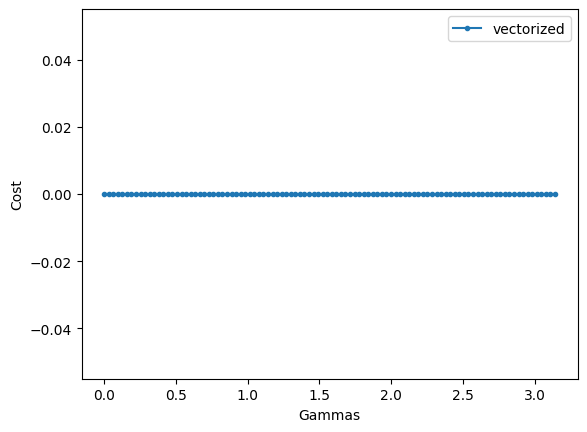

In [9]:
# prepend_state : if the initial quantum state is all zeroes, we should get zero cost all the way
psi_init = np.zeros([2] * backend_obj.n_qubits, dtype=complex)
backend_obj = QAOAvectorizedBackendSimulator(circuit_params = circuit_params, append_state = None, prepend_state = psi_init, init_hadamard = True)

# Perform sweep
gammas = np.linspace(0, np.pi, 100)
beta = 1
costs_vect, costs = np.zeros((len(gammas))), np.zeros((len(gammas)))

for i, gamma in enumerate(gammas):
    print(f"\rRunning {i}/{len(gammas)}", end="")
    args = [beta, gamma]
    
    variate_params.update_from_raw(args)
    costs_vect[i] = backend_obj.expectation_w_uncertainty(variate_params)[0]
    
plt.plot(gammas, costs_vect, label = 'vectorized', marker = '.')
plt.ylabel('Cost')
plt.xlabel('Gammas')
plt.legend()
plt.show()

In [10]:
"""
if append_state is not unitary, raise error
"""

unitary = np.zeros((2**3, 2**3), dtype=complex)
unitary[0][0] = 1
backend_obj = QAOAvectorizedBackendSimulator(circuit_params = circuit_params, append_state = unitary, prepend_state = None, init_hadamard = True)

# Perform sweep
gammas = np.linspace(0, np.pi, 100)
beta = 1
costs_vect, costs = np.zeros((len(gammas))), np.zeros((len(gammas)))

for i, gamma in enumerate(gammas):
    print(f"\rRunning {i}/{len(gammas)}", end="")
    args = [beta, gamma]
    
    variate_params.update_from_raw(args)
    costs_vect[i] = backend_obj.expectation_w_uncertainty(variate_params)[0]

Running 0/100

ValueError: append_state is not a unitary matrix

Running 99/100

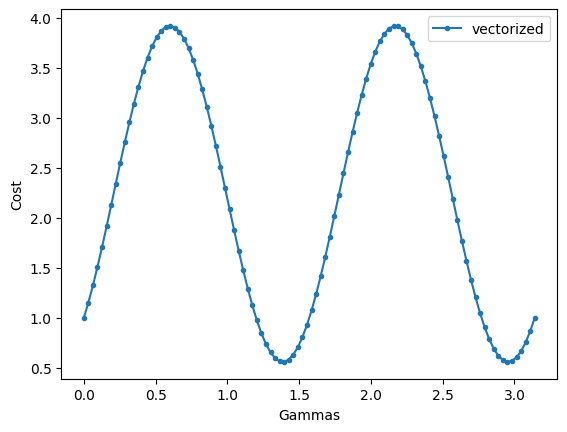

In [11]:
# append_state : apply a unitary operation to the final wavefunction

unitary = np.identity(2**backend_obj.n_qubits)
unitary[0][0] = -1
unitary[1][1] = -1
unitary[2][2] = -1
unitary[3][3] = -1
backend_obj = QAOAvectorizedBackendSimulator(circuit_params = circuit_params, append_state = unitary, prepend_state = None, init_hadamard = True)

# Perform sweep
gammas = np.linspace(0, np.pi, 100)
beta = 1
costs_vect, costs = np.zeros((len(gammas))), np.zeros((len(gammas)))

for i, gamma in enumerate(gammas):
    print(f"\rRunning {i}/{len(gammas)}", end="")
    args = [beta, gamma]
    
    variate_params.update_from_raw(args)
    costs_vect[i] = backend_obj.expectation_w_uncertainty(variate_params)[0]
    
plt.plot(gammas, costs_vect, label = 'vectorized', marker = '.')
plt.ylabel('Cost')
plt.xlabel('Gammas')
plt.legend()
plt.show()

# Test optimizer

In [12]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 10}

In [13]:
optimizer_obj = ScipyOptimizer(backend_obj, variate_params, optimizer_dict)

In [14]:
optimizer_obj

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 10

In [15]:
optimizer_obj()
optimizer_obj.results_information()

{'opt result':      fun: 0.6148911080223918
    maxcv: 0.0
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 10
   status: 2
  success: False
        x: array([1.        , 2.89159265]),
 'parameter log': [[1.0, 3.141592653589793],
  [2.0, 3.141592653589793],
  [1.0, 4.141592653589793],
  [0.999999999999999, 2.141592653589793],
  [0.9999999999999994, 2.641592653589793],
  [0.9999999999999998, 3.391592653589793],
  [0.875, 3.141592653589793],
  [1.0000000000000002, 2.891592653589793],
  [1.0000000000000004, 2.641592653589793],
  [1.0000000000000002, 2.766592653589793]],
 'final params': [1.0000000000000002, 2.891592653589793],
 'cost progress list': [0.9999999999999992,
  1.0000000000000004,
  2.1917778932607286,
  3.9100279439736467,
  1.7241137944486473,
  2.525373131117899,
  0.9999999999999992,
  0.6148911080223918,
  1.7241137944486415,
  1.0201420815474078],
 'count progress list': [],
 'probability progress list': [{'000': 0.1249999999999999,
   '10

In [16]:
optimizer_obj()
optimizer_obj.results_information()

{'opt result':      fun: 0.6148911080223918
    maxcv: 0.0
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 10
   status: 2
  success: False
        x: array([1.        , 2.89159265]),
 'parameter log': [[1.0, 3.141592653589793],
  [2.0, 3.141592653589793],
  [1.0, 4.141592653589793],
  [0.999999999999999, 2.141592653589793],
  [0.9999999999999994, 2.641592653589793],
  [0.9999999999999998, 3.391592653589793],
  [0.875, 3.141592653589793],
  [1.0000000000000002, 2.891592653589793],
  [1.0000000000000004, 2.641592653589793],
  [1.0000000000000002, 2.766592653589793],
  [1.0, 3.141592653589793],
  [2.0, 3.141592653589793],
  [1.0, 4.141592653589793],
  [0.999999999999999, 2.141592653589793],
  [0.9999999999999994, 2.641592653589793],
  [0.9999999999999998, 3.391592653589793],
  [0.875, 3.141592653589793],
  [1.0000000000000002, 2.891592653589793],
  [1.0000000000000004, 2.641592653589793],
  [1.0000000000000002, 2.766592653589793]],
 'final params': [1.00